In [2]:
import os
import math
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import ShuffleSplit

In [4]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection'
TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'

TRAIN_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/train_metadata_noidx.csv'
TEST_METADATA_SEQ_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-sequence-metadata/test_metadata_noidx.csv'

In [5]:
class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except Exception as e:
            print('\nWarning:', e.__class__.__name__, f'for {path} Replacing with zeros image')
            img = np.zeros((*tuple(resize[:2]), 3), dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)

In [6]:
class MetadataLoader:
    def __init__(self, train_metadata_path = TRAIN_METADATA_PATH, test_metadata_path = TEST_METADATA_PATH, lazy_load = True):
      self.train_metadata_path = train_metadata_path
      self.test_metadata_path = test_metadata_path
      self._lazy_load = lazy_load
      self._train_df = None
      self._test_df = None
      
      if not self._lazy_load:
        self._load_trainset()
        self._load_testset()
        
    def _read(self, is_read_train_metadata = True):
        csv_file = self.train_metadata_path
        if not is_read_train_metadata:
            csv_file = self.test_metadata_path
            
        df = pd.read_csv(csv_file)
        
        df["Image"] = df["ID"].str.slice(stop=12)
        df["Diagnosis"] = df["ID"].str.slice(start=13)
        
        if is_read_train_metadata:
            duplicates_to_remove = [
                56346, 56347, 56348, 56349,
                56350, 56351, 1171830, 1171831,
                1171832, 1171833, 1171834, 1171835,
                3705312, 3705313, 3705314, 3705315,
                3705316, 3705317, 3842478, 3842479,
                3842480, 3842481, 3842482, 3842483
            ]
            df = df.drop(index=duplicates_to_remove)
            df = df.reset_index(drop=True)
        
        df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
        df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
        
        return df

    def _load_trainset(self):
        self._train_df = self._read(is_read_train_metadata=True)
    
    def _load_testset(self):
        self._test_df = self._read(is_read_train_metadata=False)
    
    def reload_set(self):
        self._load_trainset()
        self._load_testset()
    
    @property
    def train_df(self):
        if self._train_df is not None:
            return self._train_df
        self._load_trainset()
        return self._train_df
    
    @property
    def test_df(self):
        if self._test_df is not None:
            return self._test_df
        self._load_testset()
        return self._test_df

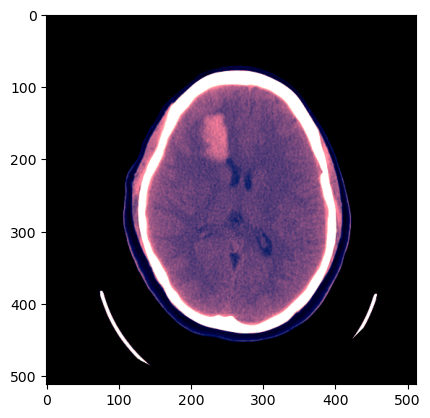

In [7]:
# Sanity check
sample_dcm_fname = f'{TRAIN_DATA_PATH}/ID_1534bee18.dcm'
dcm = pydicom.dcmread(sample_dcm_fname)
plt.imshow(ImagePreparationUtil.bsb_window(dcm), cmap=plt.cm.bone)

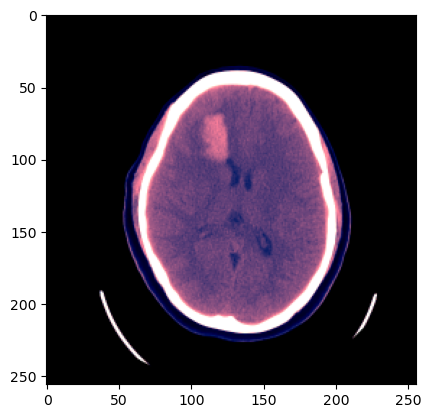

In [8]:
# Another sanity check
plt.imshow(ImagePreparationUtil.read(sample_dcm_fname, resize=(256, 256)), cmap=plt.cm.bone)

In [9]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, under_sampling=True, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)
        return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.dcm'
            img = ImagePreparationUtil.read(img_path, self.img_shape[:2])
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [10]:
class TestDataGenerator(TrainDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X = self.__data_generation(indices)
        return X
        
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.dcm'
            img = ImagePreparationUtil.read(img_path, self.img_shape[:2])
            X[i,] = img
        
        return X
    

In [11]:
class DeepModel():
    def __init__(self, base, input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, weights='imagenet', verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()
    
    def _build(self):
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape, name='inception_v3')
        # x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(base.output)
        x = base.output
        x = layers.Dense(1024, activation='relu', name='additional_dense')(x)
        x = layers.Dropout(0.15)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.Adam(),
            metrics=['acc', keras.metrics.AUC()]
        )
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            workers=128,
            use_multiprocessing=True
        )
        weights_path = f'{self.base.__name__}_{date.today().strftime("%d-%m-%Y")}'
        os.makedirs(weights_path, exist_ok=True)
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/%s-{epoch:02d}.weights.h5' % (weights_path, self.base.__name__), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=False),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)))
        ]
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs, 
            verbose=self.verbose
        )

In [12]:
df_loader = MetadataLoader()

In [13]:
df = df_loader.train_df

In [14]:
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)
# lets go for first fold only
train_idx, valid_idx = next(ss)

In [16]:
model = DeepModel(
    base=keras.applications.InceptionV3,
    input_shape=(256, 256, 3), 
    batch_size=32, 
    num_epochs=10,
    num_classes=6,
    learning_rate=1e-4, 
    decay_rate=0.8,
    decay_steps=1,
)

In [ ]:
history = model.fit(df.iloc[train_idx], df.iloc[valid_idx])

Epoch 1/10
21173/21173 ━━━━━━━━━━━━━━━━━━━━ 6876s 324ms/step - acc: 0.9169 - auc_1: 0.7246 - loss: 0.1741 - val_acc: 1.0000 - val_auc_1: 0.7147 - val_loss: 0.2545 - learning_rate: 6.4000e-05
Epoch 4/10
21173/21173 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - acc: 0.9274 - auc_1: 0.7390 - loss: 0.1703
Epoch 4: saving model to InceptionV3/InceptionV3_28-11-2024-04.weights.h5
21173/21173 ━━━━━━━━━━━━━━━━━━━━ 7181s 338ms/step - acc: 0.9274 - auc_1: 0.7390 - loss: 0.1703 - val_acc: 0.9999 - val_auc_1: 0.5959 - val_loss: 0.9887 - learning_rate: 5.1200e-05
Epoch 5/10
11849/21173 ━━━━━━━━━━━━━━━━━━━━ 58:34 377ms/step - acc: 0.8757 - auc_1: 0.7349 - loss: 0.1437

I0000 00:00:1732791595.347462    2030 service.cc:148] XLA service 0x7f6750001930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732791595.347500    2030 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
2024-11-28 10:59:56.280188: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732791599.724163    2030 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-28 11:00:04.716272: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32332', 16 bytes spill stores, 16 bytes spill loads

2024-11-28 11:00:04.799447: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1791

 8531/21173 ━━━━━━━━━━━━━━━━━━━━ 1:00:28 287ms/step - acc: 0.9252 - auc_1: 0.8115 - loss: 0.2047

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21173/21173 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - acc: 0.9391 - auc_1: 0.8212 - loss: 0.2010

2024-11-28 12:43:17.419238: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2471', 108 bytes spill stores, 108 bytes spill loads

2024-11-28 12:43:17.491143: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2471', 492 bytes spill stores, 492 bytes spill loads





Epoch 1: saving model to InceptionV3/InceptionV3_28-11-2024-01.weights.h5
21173/21173 ━━━━━━━━━━━━━━━━━━━━ 6901s 321ms/step - acc: 0.9391 - auc_1: 0.8212 - loss: 0.2010 - val_acc: 1.0000 - val_auc_1: 0.6116 - val_loss: 0.3923 - learning_rate: 1.0000e-04
Epoch 2/10
 2944/21173 ━━━━━━━━━━━━━━━━━━━━ 1:24:22 278ms/step - acc: 0.8334 - auc_1: 0.5894 - loss: 0.1447

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17323/21173 ━━━━━━━━━━━━━━━━━━━━ 17:46 277ms/step - acc: 0.9164 - auc_1: 0.7207 - loss: 0.1760

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12548/21173 ━━━━━━━━━━━━━━━━━━━━ 41:55 292ms/step - acc: 0.9217 - auc_1: 0.7283 - loss: 0.1638

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15855/21173 ━━━━━━━━━━━━━━━━━━━━ 25:55 292ms/step - acc: 0.9279 - auc_1: 0.7437 - loss: 0.1661

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21173/21173 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - acc: 0.9347 - auc_1: 0.7616 - loss: 0.1686

Epoch 5: saving model to InceptionV3/InceptionV3_28-11-2024-05.weights.h5
21173/21173 ━━━━━━━━━━━━━━━━━━━━ 6974s 329ms/step - acc: 0.9347 - auc_1: 0.7616 - loss: 0.1686 - val_acc: 1.0000 - val_auc_1: 0.5887 - val_loss: 3.1696 - learning_rate: 4.0960e-05
Epoch 6/10
 1995/21173 ━━━━━━━━━━━━━━━━━━━━ 1:39:04 310ms/step - acc: 0.7259 - auc_1: 0.6433 - loss: 0.1180

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6118/21173 ━━━━━━━━━━━━━━━━━━━━ 1:16:21 304ms/step - acc: 0.8542 - auc_1: 0.6767 - loss: 0.1487

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17460/21173 ━━━━━━━━━━━━━━━━━━━━ 19:57 323ms/step - acc: 0.9180 - auc_1: 0.7433 - loss: 0.1627

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14674/21173 ━━━━━━━━━━━━━━━━━━━━ 38:45 358ms/step - acc: 0.9100 - auc_1: 0.7387 - loss: 0.1585

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3902/21173 ━━━━━━━━━━━━━━━━━━━━ 1:26:05 299ms/step - acc: 0.8020 - auc_1: 0.6356 - loss: 0.1319

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8936/21173 ━━━━━━━━━━━━━━━━━━━━ 1:05:12 320ms/step - acc: 0.8715 - auc_1: 0.6855 - loss: 0.1477

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



21173/21173 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - acc: 0.9123 - auc_1: 0.7478 - loss: 0.1569
Epoch 8: saving model to InceptionV3/InceptionV3_28-11-2024-08.weights.h5
21173/21173 ━━━━━━━━━━━━━━━━━━━━ 8143s 384ms/step - acc: 0.9123 - auc_1: 0.7478 - loss: 0.1569 - val_acc: 0.9998 - val_auc_1: 0.5826 - val_loss: 7.8395 - learning_rate: 2.0972e-05
Epoch 9/10
 5154/21173 ━━━━━━━━━━━━━━━━━━━━ 1:38:02 367ms/step - acc: 0.8247 - auc_1: 0.6747 - loss: 0.1338

In [ ]:
history.history

import os
import math
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import ShuffleSplit
import os
import math
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import ShuffleSplit
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhag

In [164]:
test_df = df_loader.train_df
neg = test_df[test_df['Label']['any'] == 0].sample(n=5)
epi = test_df[test_df['Label']['epidural'] == 1].sample(n=5)
intrp = test_df[test_df['Label']['intraparenchymal'] == 1].sample(n=5)
intrv = test_df[test_df['Label']['intraventricular'] == 1].sample(n=5)
subr = test_df[test_df['Label']['subarachnoid'] == 1].sample(n=5)
subd = test_df[test_df['Label']['subdural'] == 1].sample(n=5)


test_df = pd.concat([neg, epi, intrp, intrv, subr, subd])
test_df = test_df.sample(frac=1)

In [ ]:
test_df.iloc[0]

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_331e42801     1        0                1                0            1   
ID_d0e6ee138     1        0                1                0            1   
ID_356e5c75f     1        0                1                1            0   
ID_fa445fde9     1        1                0                0            0   
ID_5e99e2553     1        1                0                1            0   
ID_5a0ec1a19     1        0                1                1            1   
ID_bdb95eca8     1        0                0                0            0   
ID_d51bbdfa4     1        0                0                0            1   
ID_a0438a5a4     1        0                1                1            0   
ID_f312cd723     1        0                1                0            0   
ID_76adb3a8a     1        1                1                1            0   
ID_87b935670     1        1                1                0            1   
ID_4dfd89ef4     1        0                1                1            0   
ID_851bcb8ce     1        0                0                1            0   
ID_9bcd1e95f     0        0                0                0            0   
ID_f4d0635fe     0        0                0                0            0   
ID_fde6b1e10     1        0                1                0            1   
ID_d8d11e38a     1        1                1                0            0   
ID_6da059270     1        0                1                0            0   
ID_197ab3adc     1        0                0                0            0   
ID_d458e0d0b     1        1                0                0            0   
ID_896022330     0        0                0                0            0   
ID_df1712135     0        0                0                0            0   
ID_503a9432d     0        0                0                0            0   
ID_cffb6c225     1        0                1                1            0   
ID_2a0015d1e     1        0                0                0            0   
ID_157863dc6     1        0                0                0            1   
ID_d7c4aeb4c     1        0                1                1            0   
ID_3ab3ca1ba     1        0                1                0            0   
ID_5a1dc6a8f     1        0                0                0            1   

                       
Diagnosis    subdural  
Image                  
ID_331e42801        0  
ID_d0e6ee138        0  
ID_356e5c75f        0  
ID_fa445fde9        0  
ID_5e99e2553        1  
ID_5a0ec1a19        0  
ID_bdb95eca8        1  
ID_d51bbdfa4        0  
ID_a0438a5a4        1  
ID_f312cd723        1  
ID_76adb3a8a        0  
ID_87b935670        1  
ID_4dfd89ef4        0  
ID_851bcb8ce        0  
ID_9bcd1e95f        0  
ID_f4d0635fe        0  
ID_fde6b1e10        1  
ID_d8d11e38a        0  
ID_6da059270        0  
ID_197ab3adc        1  
ID_d458e0d0b        0  
ID_896022330        0  
ID_df1712135        0  
ID_503a9432d        0  
ID_cffb6c225        0  
ID_2a0015d1e        1  
ID_157863dc6        0  
ID_d7c4aeb4c        0  
ID_3ab3ca1ba        0  
ID_5a1dc6a8f        0

In [190]:
len(test_df.index)

30

In [192]:
test_data_gen = TrainDataGenerator(
        img_ids=test_df.index, 
        labels=test_df,
        img_dir=TRAIN_DATA_PATH,
        img_shape=(256, 256, 3),
        num_classes=6,
        batch_size=len(test_df.index),
        workers=128,
        use_multiprocessing=True,
        shuffle_on_epoch_end=False,
        under_sampling=False
)

In [195]:
X_test, y_test = test_data_gen[0]

In [ ]:
y_test_pred = model.model(X_test, training=False)

In [ ]:
y_test_pred = y_test_pred.numpy()

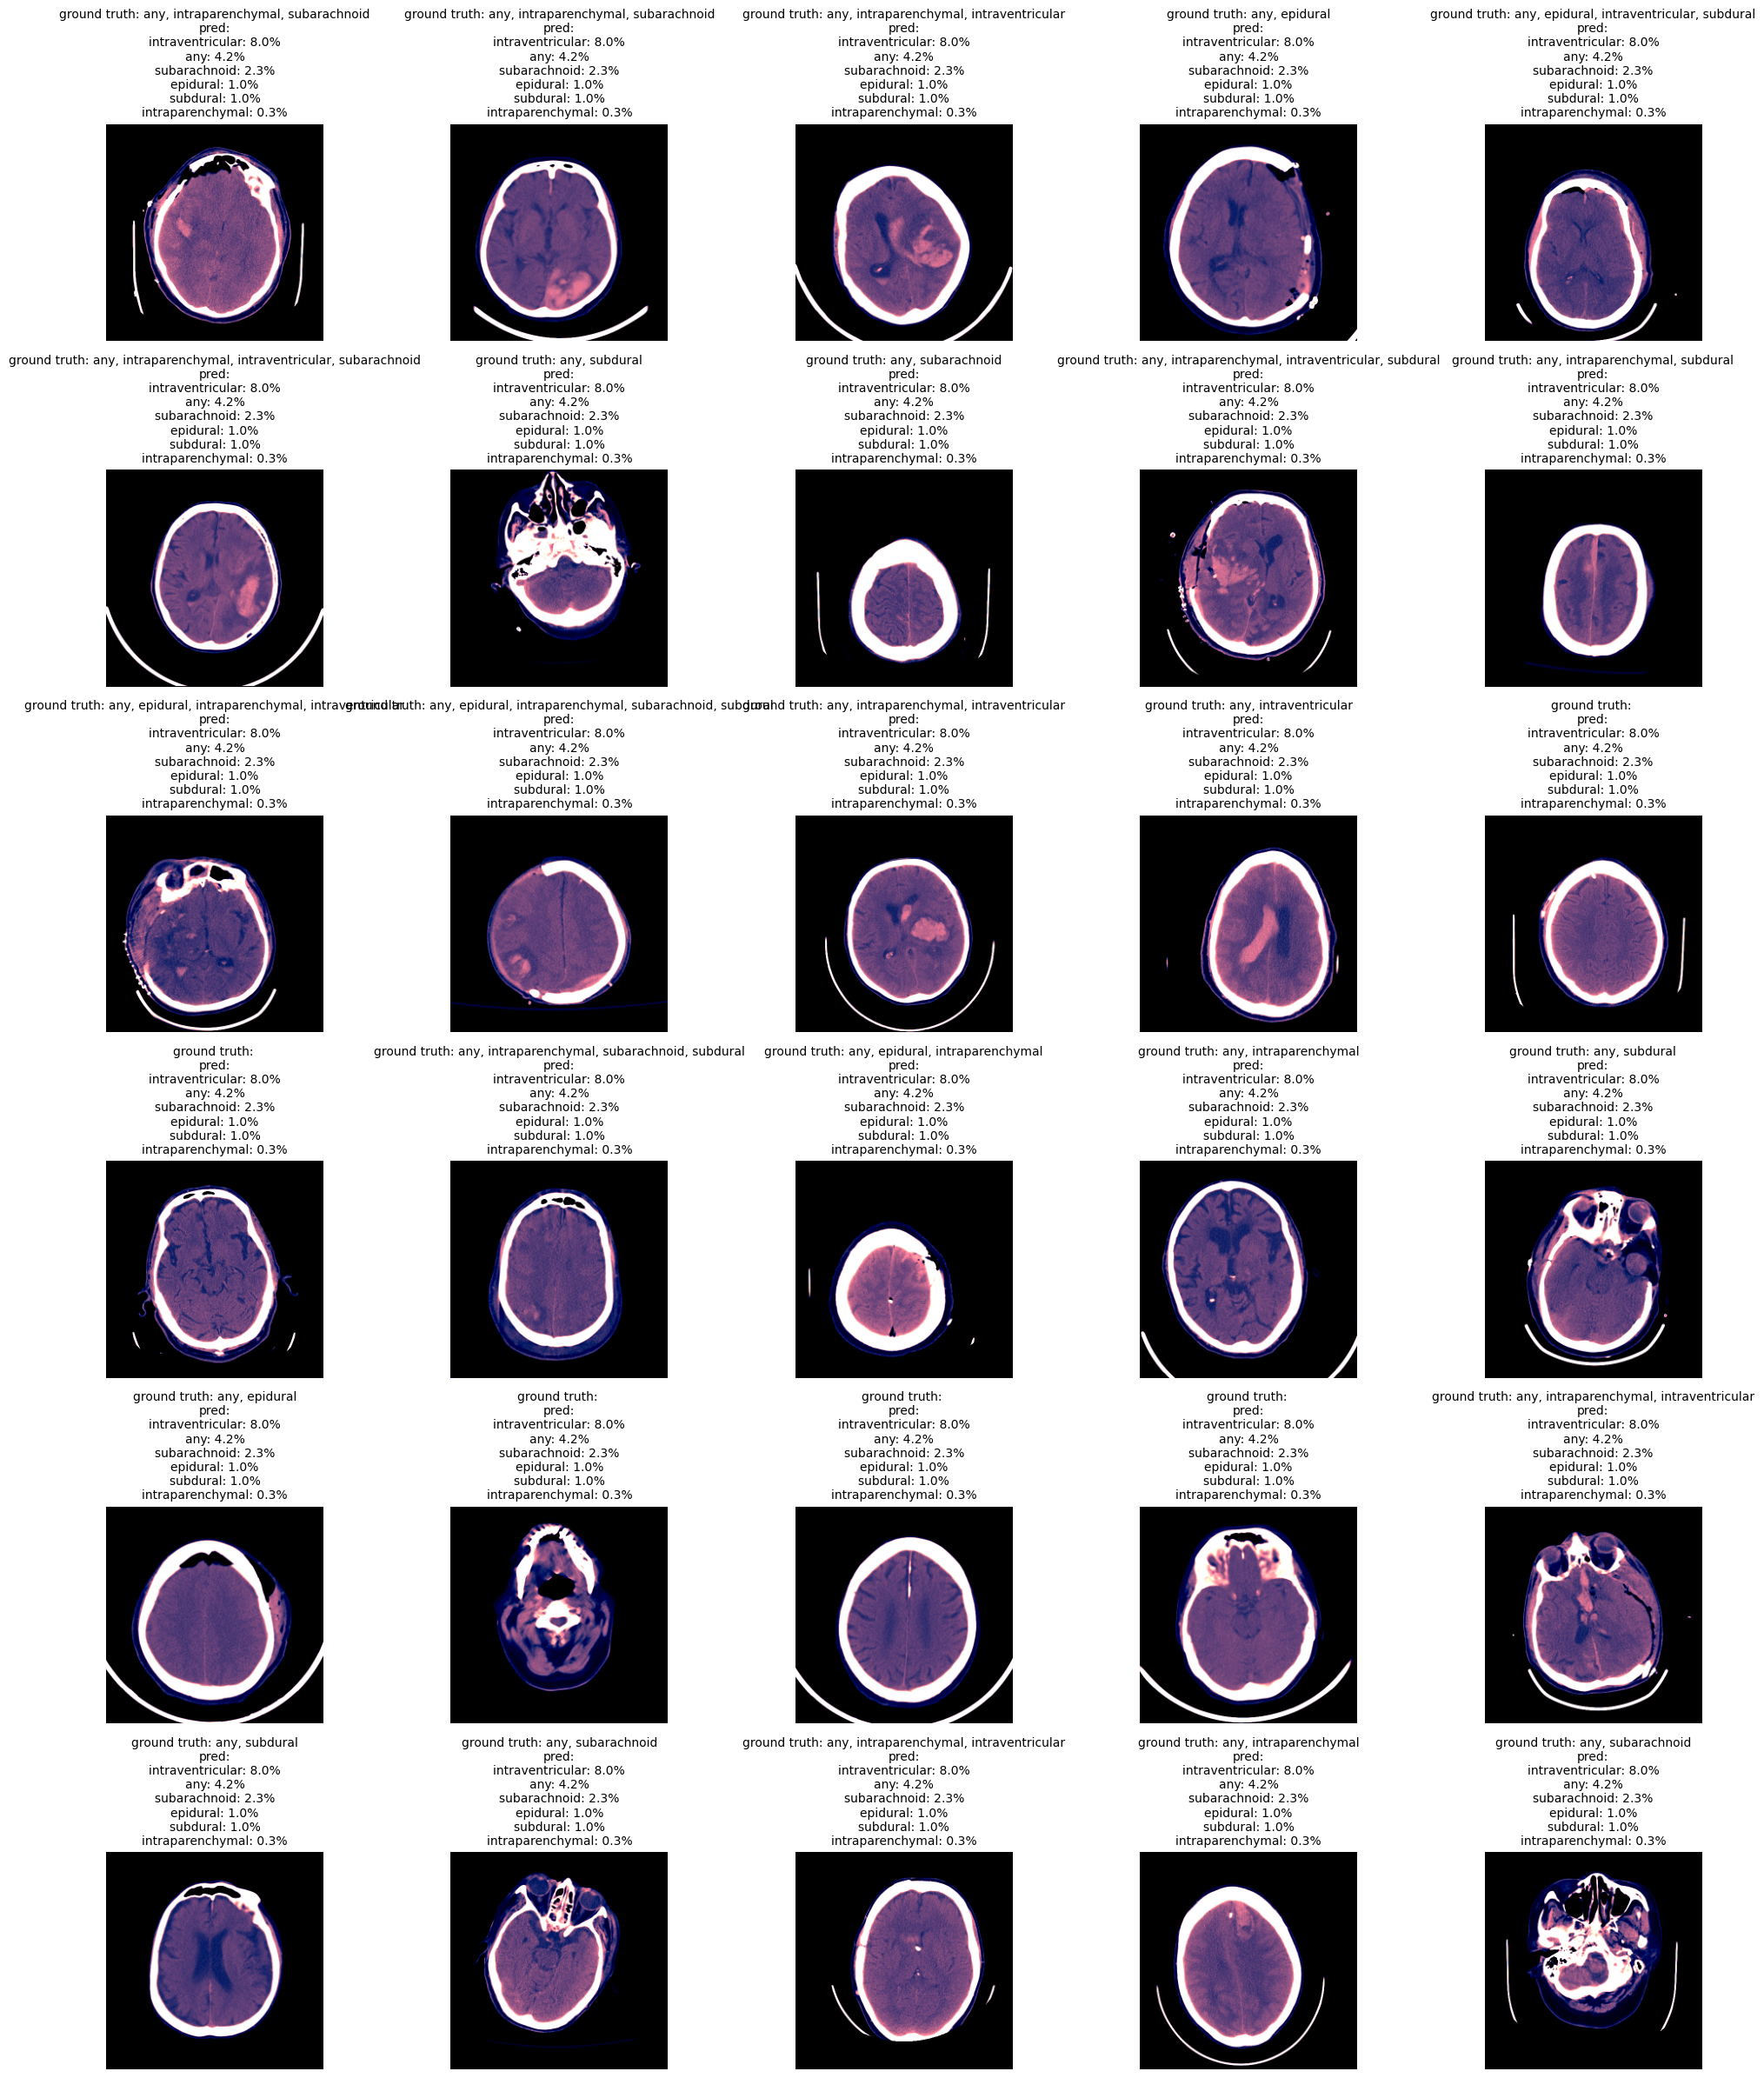

In [299]:
# sanity check
N, M = int(np.ceil(len(y_test_pred)/5)), 5
fig, axes = plt.subplots(N, M, figsize=(M*4,N*4))

classes = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']


for i, ax in enumerate(axes.flat):
    if i < len(y_test_pred):
        ground_truth = 'ground truth: ' + ', '.join(test_df['Label'].columns[(test_df == 1).iloc[i]])
        predicted = '\npred:\n' + '\n'.join(f"{key}: {value * 100:.1f}%"  for key, value in sorted(dict(zip(classes, y_test_pred[i])).items(), key=lambda item: item[1], reverse=True))
        ax.imshow(X_test[i], cmap=plt.cm.bone)
        ax.axis('off')
        ax.set_title(ground_truth + predicted)
        ax.title.set_size(10)
    else:
        ax.axis('off')

fig.tight_layout()
fig.show()